In [11]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim.models import Phrases
from gensim.models.phrases import Phraser 

#spacy for lemmatizaion
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [12]:
##Data Preparation

#import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()#first n lines


#NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#remove emails and newlines
# Convert to list
data = df.content.values.tolist()

#Remove Emails
data = [re.sub('\S*@\S*\s?','',sent) for sent in data] #list comprehension
# regular expression  \S:non_whitespace char  \s:whitespace char

#Remove new lne characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distractig single quotes
data = [re.sub("\'","", sent) for sent in data]

##Tokenize words and Clean-up text
#generator function produces next results and returns generator object
def get_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))#deacc=True removes punctuation
        
data_words = list(get_words(data))

##Creating Bigram abd Trigram Models
#Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) #higher threshold fewer words
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster ways to get a sentence clubbed as trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# see trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

##Remove Stop words, Make Bigrams and Lemmatize¶
#Define functions for stop words, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigram(texts):
    return [trigram_mod[bigram[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#call fxs
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

#Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

##Create Dictionary and Corpus needed for Topic Modelling
#Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

#Create Corpus
texts = data_lemmatized

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] #doc2bow: document to bag of words

#View
print(corpus[:1])
print(id2word[0])

#human readable format of corpus (term-frequency)
[[(id2word[id],freq) for id, freq in cp] for cp in corpus[:1]]


['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/feiyyfrank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']
[['where', 'thing', 'car', 'nntp_poste', 'host', 'park'

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

### Building the Topic Model

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### LDAWordCloud Demonstration

In [14]:
class LDAWordCloud(object):
    """Create a Word Cloud for each topic and color words by per word topics
    
    Parameters
    ---------
    lda_model: object
        LDA model by gensim
    
    id2word: dict(int -> str)
        dictionary of id to word mapping
        
    top_n: int
        number of top words to be shown in a topic
    
    """
    
    import math
    from wordcloud import WordCloud, STOPWORDS
    
    #variables
    lda_model = None
    id2word = {}
    top_n = 0
    
    def __init__ (self, lda_model, id2word, top_n):
        self.lda_model = lda_model
        self.id2word = id2word
        self.top_n = top_n
        
   
    def color_group(self):
        """ 
            Generate the color_to_words dictionary dict(str -> list(str))
            A dictionary that maps a color to the list of words. 
            e.g.{'#FF0000', ['A', 'B']}

            GenerateColorToWord requires a list of top words in various topics.
        """
        
        #collect word occurence dictionary
        word_occur_dict = self.word_occur()
        word_color = LDAWordCloud.colorMapping(self.top_n, word_occur_dict)
        colorGroupDict = {}
        for pair in word_color:
            word = pair[0]
            color = pair[1]
            if color not in colorGroupDict:
                colorGroupDict[color] = []
            colorGroupDict[color].append(word)
        return colorGroupDict

    def plot_topic(self, n):
        #get list of words for topic n
        topic_words = lda_model.get_topic_terms(n, topn = 20)
        
        #construct word-freqency dictionary (str -> int)
        ratio = int(1000/topic_words[0][1])

        word_dict = {}
        for id_prob in topic_words:
            word_dict[id2word[id_prob[0]]] = int(id_prob[1]*ratio)
        
        #generate wordcloud from model and recolor by color group 
        default_color = 'blue'
        color_to_words = self.color_group()        #color group dictionary
        grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
        wc = WordCloud(background_color="white").fit_words(word_dict)
        wc.recolor(color_func=grouped_color_func)
        
        #plot
        plt.figure()
        plt.imshow(wc)
        plt.axis("off")
        plt.title("Topic #" + str(n))
        plt.show()
        
    def colorMapping(topic_n, word_occur):
        """ 
            Frequency-Color Mapping (topic count n, occurrence_dict)

            For each word in top words:Assign to map if this frequency not in processed
        """
        word_color = [(pair[0], LDAWordCloud.occur2color(pair[1],20)) for pair in word_occur]
        return word_color

    @staticmethod
    def occur2color(occur, base):
        """
            If occurs in n topics,

            Log(1) = 0 -> 0
            logN(n)= k -> 255
            LogN(N) = 1 -> 255
        """
        
        import math
        
        if(occur <= 1):
            color_num = 0
        else:
            color_num = int(math.log(occur,base)*255*2)

        if(color_num>255):
            color_num = 255
        
        #return color in hex
        return '#' + format(color_num, '02x') + format(color_num, '02x') + format(color_num, '02x')
    
    def word_occur(self):
        #construct all_words list
        all_words = []
        for t in range(self.lda_model.num_topics):
            topic_words = self.lda_model.get_topic_terms(t, topn = self.top_n)
            for id_prob in topic_words:
                all_words.append(id2word[id_prob[0]])

        #construct word-occurrence dict
        occur = []
        for w in all_words:
            occur.append(all_words.count(w))
        word_occur = list(zip(all_words, occur))
        #print(word_occur)
        return word_occur
    
    def __call__(self, lda_model, id2word, top_n, **kwargs):
        for t in range(lda_model.num_topics):
            self.plot_topic(t)

In [15]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


### Visualize Topic-keywords of a specific topic with LDAWordCloud

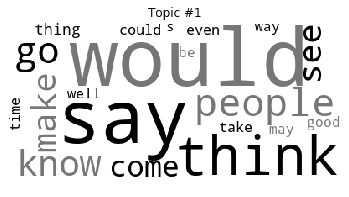

In [16]:
ldawc = LDAWordCloud(lda_model, id2word, 20)
ldawc.plot_topic(1)

### Visualize Topic-keywords of all topics with LDAWordCloud

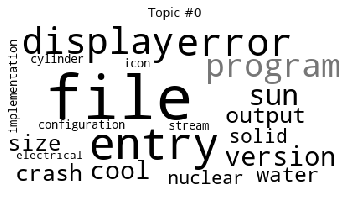

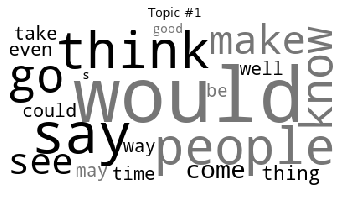

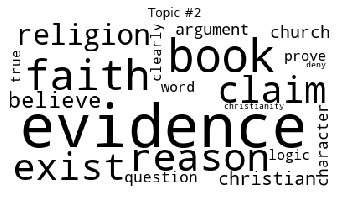

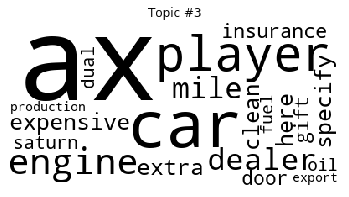

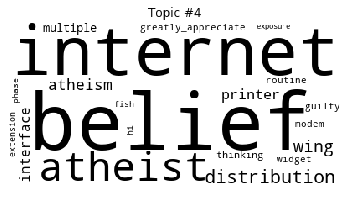

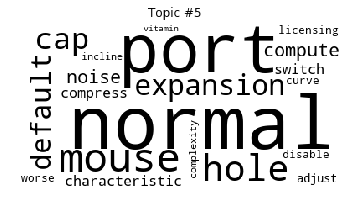

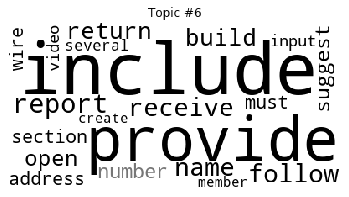

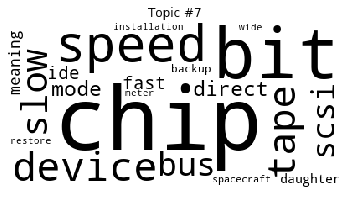

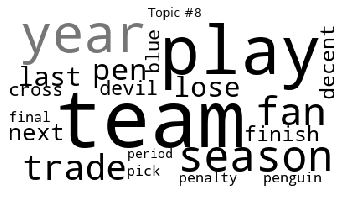

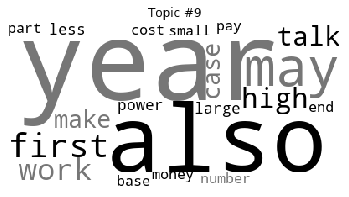

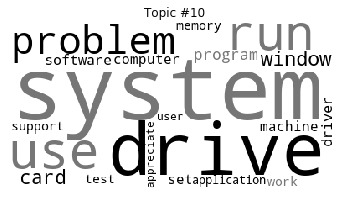

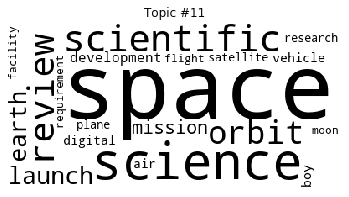

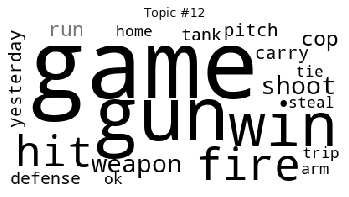

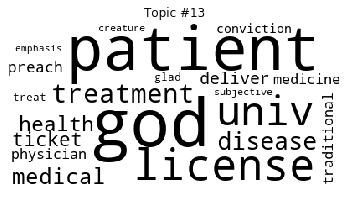

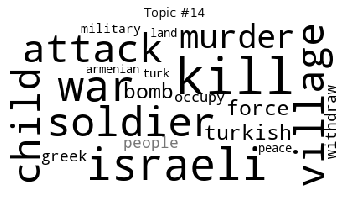

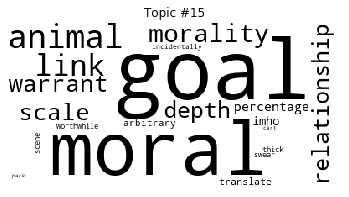

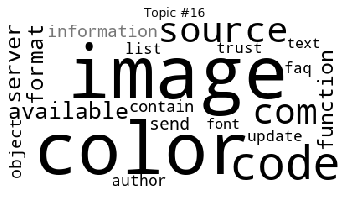

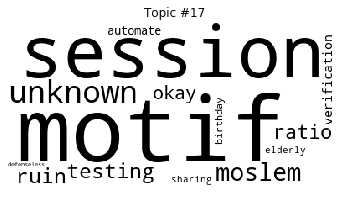

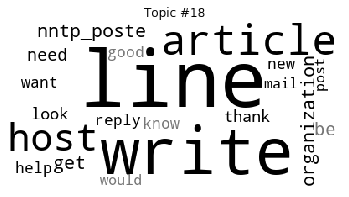

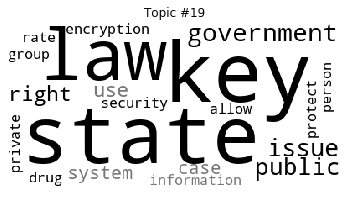

In [17]:
ldawc(lda_model, id2word, 20)

### Visualize Topic-keywords with pyLDAvis

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.335626 -0.217762       1        1  28.084330
18    -0.302100 -0.145066       2        1  18.155695
9     -0.271856 -0.004572       3        1  15.585500
19    -0.213885  0.101579       4        1   8.161822
3      0.014733  0.121571       5        1   5.748534
10    -0.144854  0.268488       6        1   5.679704
6     -0.129735  0.185621       7        1   5.135422
2     -0.061821 -0.076504       8        1   2.129594
14    -0.017999 -0.093231       9        1   1.930799
16     0.000156  0.059405      10        1   1.922795
11     0.069653  0.074435      11        1   1.423903
0      0.119178  0.020963      12        1   1.152290
12     0.109101 -0.008043      13        1   1.039399
8      0.085481 -0.055242      14        1   0.971933
7      0.131148 -0.010041      15        1   0.884551
4      0.160739 -0.037293      16        1   0.697296
13     0.172288 -0.042781      17        1   0.449755
15     0.198405 -0.044216      18        1   0.375347
5      0.200340 -0.048547      19        1   0.334444
17     0.216656 -0.048765      20        1   0.136888, topic_info=              Term          Freq         Total Category  logprob  loglift
3718            ax  36366.000000  36366.000000  Default  30.0000  30.0000
18            line  15682.000000  15682.000000  Default  29.0000  29.0000
197          write  13139.000000  13139.000000  Default  28.0000  28.0000
39            year   4567.000000   4567.000000  Default  27.0000  27.0000
140         people   7716.000000   7716.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
6226  redistribute      0.026008      1.250145  Topic20 -11.0266   2.7211
6951     judgement      0.026008      1.250163  Topic20 -11.0266   2.7211
9115      tomorrow      0.026008      1.250168  Topic20 -11.0266   2.7211
5664  announcement      0.026008      1.250196  Topic20 -11.0266   2.7211
4072          baby      0.026008      1.250173  Topic20 -11.0266   2.7211

[866 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1227      1  0.999084        accept
345      15  0.914020    acceptance
326      17  0.943326  accidentally
0         7  0.998100      addition
175       2  0.399790       address
...     ...       ...           ...
39        1  0.028244          year
39        3  0.824330          year
39       14  0.147350          year
722      13  0.992128     yesterday
570       1  0.998440         young

[1113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 10, 20, 4, 11, 7, 3, 15, 17, 12, 1, 13, 9, 8, 5, 14, 16, 6, 18])

In [ ]:
###TO DO

#match with topic index in pyLDAvis that is to sort by relavance
#Estimated term frequency

### Evaluation

In [ ]:
###TO DO

#change number of nopics to see if this visualization reflects coherence score

#model perplexity: degree of comfusion, normalized inversion of probability, desire to be low
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#topic distribution across documents

### Application

In [ ]:
###TO DO